In [1]:
import sys

In [2]:
import os
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tqdm
from pathlib import Path

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
from torchvision import models

from PIL import Image 
import albumentations as A
from albumentations.pytorch import ToTensorV2

from sklearn.metrics import confusion_matrix, classification_report, top_k_accuracy_score
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

RANDOM_SEED=42
torch.manual_seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)
if torch.cuda.is_available:
    torch.cuda.manual_seed(RANDOM_SEED)

In [8]:
# Check device
device=torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')
if torch.cuda.is_available:
    print(f'GPU: {torch.cuda.get_device_name(0)}')
    print(f'Memory: {torch.cuda.get_device_properties(0).total_memory/1e9:.2f}GB')

Using device: cuda
GPU: NVIDIA GeForce RTX 3050 Laptop GPU
Memory: 4.29GB


In [9]:
# Initial declaration
DATASET_PATH='../../data/food-101/food-101/images'
TRAIN_CSV='../../data/food-101/food-101-preprocessed/train_df.csv'
VAL_CSV='../../data/food-101/food-101-preprocessed/val_df.csv'
TEST_CSV='../../data/food-101/food-101-preprocessed/test_df.csv'

MODEL_NAME='resnet50'
NUM_CLASSES=101
IMG_SIZE=224   
BATCH_SIZE=16
NUM_EPOCHS=10
LEARNING_RATE=0.001
NUM_WORKERS=4

SAVE_MODEL_PATH='../../models'
SAVE_RESULTS_PATH='../../results'

In [10]:
# Augmentation
train_transform=A.Compose([
    A.HorizontalFlip(p=0.5),
    A.Rotate(limit=15, p=0.3),
    A.Affine(translate_percent={'x':0.1, 'y':0.1}, scale=(0.9, 1.1), rotate=(+15, -15), p=0.3),

    A.RandomBrightnessContrast(brightness_limit=0.2, contrast_limit=0.2, p=0.5),
    A.HueSaturationValue(hue_shift_limit=10, sat_shift_limit=20, val_shift_limit=10, p=0.5),

    A.GaussNoise(var_limit=(10, 30), p=0.3),
    A.GaussianBlur(blur_limit=(3,5), p=0.2),

    A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ToTensorV2()
])

val_test_transform=A.Compose([
    A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ToTensorV2()
])

C:\Users\asus\AppData\Local\Temp\ipykernel_36624\731977300.py:10: UserWarning: Argument(s) 'var_limit' are not valid for transform GaussNoise
  A.GaussNoise(var_limit=(10, 30), p=0.3),


In [11]:
# PyTorch Dataset objects
class Food101Dataset(Dataset):
    def __init__(self, csv_file, root_dir, transform=None):
        self.df=pd.read_csv(csv_file)
        self.root_dir=root_dir
        self.transform=transform

        self.classes=sorted(self.df['class_name'].unique())
        self.cls_to_idx={cls: idx for idx, cls in enumerate(self.classes)} # Encode
        self.idx_to_cls={idx: cls for idx, cls in enumerate(self.classes)} # Decode

        print(f'Dataset loaded: {len(self.df)} images, {len(self.classes)} classes.')

    def __len__(self):
        return(len(self.df))
    
    def __getitem__(self, idx):
        img_path=self.df.iloc[idx]['image_path']
        img=Image.open(img_path).convert('RGB')
        img=img.resize((IMG_SIZE, IMG_SIZE))
        img=np.array(img)

        class_name=self.df.iloc[idx]['class_name'] 

        label=self.cls_to_idx[class_name]

        if self.transform: # Transform image from NumPy arrays to PyTorch tensor
            transformed=self.transform(image=img)
            img=transformed['image']

        return img, label
    
    def get_class_name(self, idx):
        return self.idx_to_cls[idx]

Dataset loaded: 70700 images, 101 classes.
Dataset loaded: 15150 images, 101 classes.
Dataset loaded: 15150 images, 101 classes.

Data loading test
Image batch shape: torch.Size([16, 3, 224, 224])
Labels shape: torch.Size([16])


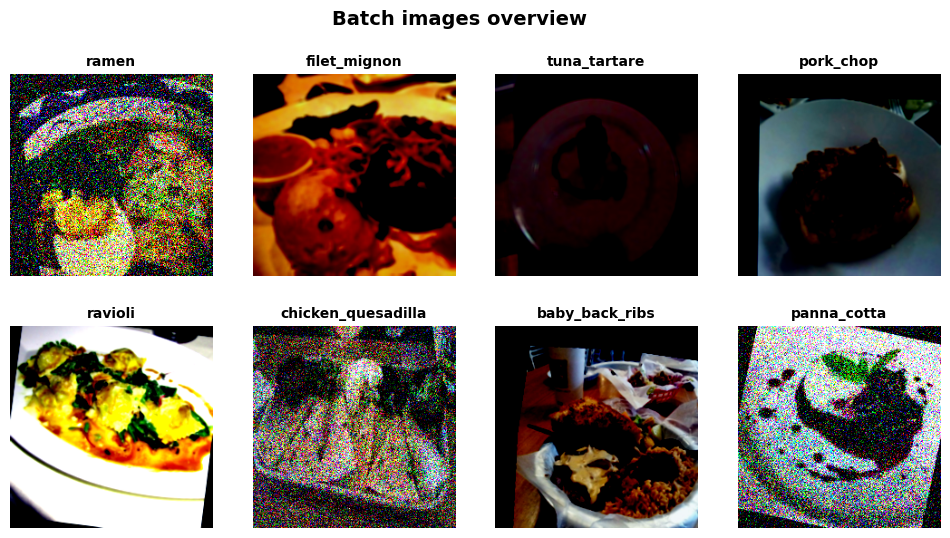

In [12]:
# Dataset objects
train_dataset=Food101Dataset(
    csv_file=TRAIN_CSV,
    root_dir='',
    transform=train_transform
)

val_dataset=Food101Dataset(
    csv_file=VAL_CSV,
    root_dir='',
    transform=val_test_transform
)

test_dataset=Food101Dataset(
    csv_file=TEST_CSV,
    root_dir='',
    transform=val_test_transform
)

# DataLoaders
train_loader=DataLoader(
    dataset=train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=0,
    pin_memory=True
)

val_loader=DataLoader(
    dataset=val_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False, 
    num_workers=0,
    pin_memory=True
)

test_loader=DataLoader(
    dataset=test_dataset, 
    batch_size=BATCH_SIZE,
    shuffle=False, 
    num_workers=0,
    pin_memory=True
)

print(f'\nData loading test')
batches, labels=next(iter(train_loader))
print(f'Image batch shape: {batches.shape}')
print(f'Labels shape: {labels.shape}')

# Batch viz
fig, ax=plt.subplots(2, 4, figsize=(12, 6))
ax=ax.flatten()

mean=np.array([0.485, 0.456, 0.406])
std=np.array([0.229, 0.224, 0.225])

for i in range(8):
    img=batches[i].permute(1, 2, 0).cpu().numpy()
    img=img * mean + std
    img=np.clip(img, 0, 1)

    ax[i].imshow(img)
    class_name=train_dataset.get_class_name(labels[i].item())
    ax[i].set_title(f'{class_name}', fontsize=10, fontweight='bold')
    ax[i].axis('off')

plt.suptitle('Batch images overview', fontsize=14, fontweight='bold')
plt.savefig('figures/batch_images_sample', dpi=300, bbox_inches='tight')
plt.show()

In [13]:
# Model definition
def build_model(model_name='resnet50', num_classes=101, pretrained=True):

    if model_name=='resnet50':
        if pretrained:
            model=models.resnet50(weights=models.ResNet50_Weights.IMAGENET1K_V2)
        else:
            model=models.resnet50(weights=None)
        num_features=model.fc.in_features
        model.fc=nn.Linear(num_features, num_classes)
    elif model_name=='efficientnet_b0':
        if pretrained:
            model=models.efficientnet_b0(weights=models.EfficientNet_B0_Weights.IMAGENET1K_V1)
        else:
            model=models.efficientnet_b0(weights=None)
        num_features=model.fc.in_features
        model.classifier[1]=nn.Linear(num_features, num_classes)
    elif model_name=='mobilenet_v2':
        if pretrained:
            model=models.mobilenet_v2(weights=models.MobileNet_V2_Weights.IMAGENET1K_V2)
        else:
            model=models.mobilenet_v2(weights=None)
        num_features=model.fc.in_features
        model.classifier[1]=nn.Linear(num_features, num_classes)

    else:
        raise ValueError(f'Unknown model: {model_name}')
    
    return model

model=build_model(MODEL_NAME, NUM_CLASSES, pretrained=True)
model=model.to(device) 

# Parameters info
total_params=sum(p.numel() for p in model.parameters())
trainable_params=sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'Parameter overview')
print(f'Total parameters: {total_params}')
print(f'Trainable parameters: {trainable_params}')
print(f'Model location: {next(model.parameters()).device}')

Parameter overview
Total parameters: 23714981
Trainable parameters: 23714981
Model location: cuda:0


In [14]:
# Loss function and optimizer
criterion=nn.CrossEntropyLoss()

optimizer=optim.Adam(model.parameters(), lr=LEARNING_RATE)

scheduler=optim.lr_scheduler.ReduceLROnPlateau(
    optimizer,
    mode='max',
    factor=0.5,
    patience=2,
    verbose=True
)

d:\work\me-food\venv\Lib\site-packages\torch\optim\lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


In [15]:
# Training functions
def train_one_epoch(model, loader, criterion, optimizer, device): 
    model.train()
    running_loss=0.0
    correct=0
    total=0

    pbar=tqdm.tqdm(loader, desc='Training')
    for images, labels, in pbar:
        images, labels=images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs=model(images) # Forward pass
        loss=criterion(outputs, labels)

        loss.backward() # Backward pass
        optimizer.step()

        running_loss+=loss.item() 
        _, predicted=outputs.max(1)
        correct+=predicted.eq(labels).sum().item()
        total+=labels.size(0)

        pbar.set_postfix({
            'loss': f'{running_loss/len(loader):.2f}',
            'acc': f'{100.*correct/total:.2f}%'
        }) 

    epoch_loss=running_loss/len(loader)
    epoch_acc=100.*correct/total
    
    return epoch_loss, epoch_acc

# Validation function
def validate_model(model, loader, criterion, device):
    model.eval()
    running_loss=0.0
    correct=0
    total=0

    with torch.no_grad():
        pbar=tqdm.tqdm(loader, desc='Validating')
        for images, labels in pbar:
            images, labels=images.to(device), labels.to(device)

            outputs=model(images)
            loss=criterion(outputs, labels)

            running_loss+=loss.item()
            _, predicted=outputs.max(1) 
            correct+=predicted.eq(labels).sum().item()
            total+=labels.size(0)
            
            pbar.set_postfix({
                'loss': f'{running_loss/len(loader):.2f}',
                'acc': f'{100.*correct/total:.2f}%'
            })

    epoch_loss=running_loss/len(loader)
    epoch_acc=100.*correct/total

    return epoch_loss, epoch_acc 

In [ ]:
# Model training
history = {
    'train_loss': [],
    'train_acc': [],
    'val_loss': [],
    'val_acc': []
}

best_val_acc = 0.0
best_epoch = 0

for epoch in range(NUM_EPOCHS):
    print(f"\nEpoch [{epoch+1}/{NUM_EPOCHS}]")

    train_loss, train_acc = train_one_epoch(model, train_loader, criterion, optimizer, device)

    val_loss, val_acc = validate_model(model, val_loader, criterion, device)

    history['train_loss'].append(train_loss)
    history['train_acc'].append(train_acc)  
    history['val_loss'].append(val_loss)
    history['val_acc'].append(val_acc)
    
    scheduler.step(val_acc)

    print(f"Epoch {epoch+1} Summary:")
    print(f"Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.2f}%")
    print(f"Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.2f}%")
    
    # Save best model
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        best_epoch = epoch + 1
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'val_acc': val_acc,
        }, f'{SAVE_MODEL_PATH}/best_model.pth')
        print(f"Best model: Val Acc: {val_acc:.2f}%)")

print(f"Best validation accuracy: {best_val_acc:.2f}% (Epoch {best_epoch})")

# Save training history
with open(f'{SAVE_RESULTS_PATH}/training_history.json', 'w') as f:
    json.dump(history, f, indent=2)

Best validation accuracy: 0.00% (Epoch 0)


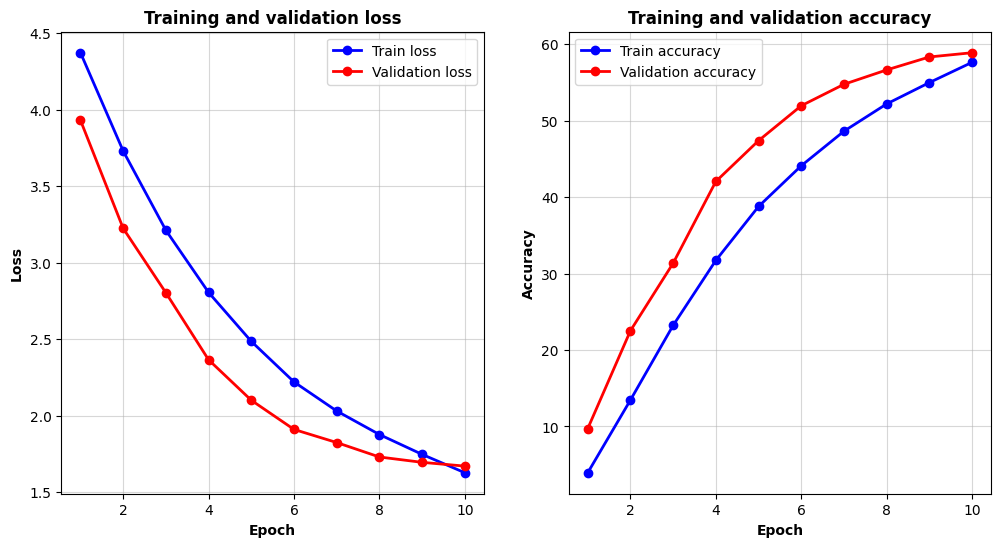

In [16]:
# Load results
with open(f'{SAVE_RESULTS_PATH}/training_history.json', 'r') as hist:
    history=json.load(hist)

# Training history viz
fig, ax=plt.subplots(1, 2, figsize=(12, 6))

epochs=range(1, NUM_EPOCHS + 1)

ax[0].plot(epochs, history['train_loss'], 'b-o', label='Train loss', linewidth=2)
ax[0].plot(epochs, history['val_loss'], 'r-o', label='Validation loss', linewidth=2)
ax[0].set_xlabel(f'Epoch', fontsize=10, fontweight='bold')
ax[0].set_ylabel(f'Loss', fontsize=10, fontweight='bold')
ax[0].set_title(f'Training and validation loss', fontsize=12, fontweight='bold')
ax[0].legend()
ax[0].grid(alpha=0.5)

ax[1].plot(epochs, history['train_acc'], 'b-o', label='Train accuracy', linewidth=2)
ax[1].plot(epochs, history['val_acc'], 'r-o', label='Validation accuracy', linewidth=2)
ax[1].set_xlabel(f'Epoch', fontsize=10, fontweight='bold')
ax[1].set_ylabel(f'Accuracy', fontsize=10, fontweight='bold')
ax[1].set_title(f'Training and validation accuracy', fontsize=12, fontweight='bold')
ax[1].legend()
ax[1].grid(alpha=0.5)

plt.savefig('figures/training_history', dpi=300, bbox_inches='tight')
plt.show()

In [17]:
checkpoint=torch.load(f'{SAVE_MODEL_PATH}/best_model.pth')
model.load_state_dict(checkpoint['model_state_dict'])
model=model.to(device)
model.eval()

print(f'Best model epoch: Epoch {checkpoint['epoch']+1}')
print(f'Best accuracy: {checkpoint['val_acc']:.2f}')

Best model epoch: Epoch 10
Best accuracy: 58.90


In [18]:
# Model evaluation
def evaluate_model(model, loader, device, dataset, k_values=[1, 3, 5]):
    """
    Comprehensive model evaluation
    
    Returns:
        all_labels: True labels
        all_preds: Predicted labels
        all_probs: Prediction probabilities
    """
    model.eval()
    all_labels = []
    all_preds = []
    all_probs = []

    with torch.no_grad():
        for images, labels in tqdm.tqdm(loader, desc='Evaluating'):
            images=images.to(device)
            outputs=model(images)
            probs=torch.softmax(outputs, dim=1)

            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(outputs.argmax(1).cpu().numpy())
            all_probs.extend(probs.cpu().numpy())

    all_labels=np.array(all_labels)
    all_preds=np.array(all_preds)
    all_probs=np.array(all_probs)

    for k in k_values: 
        top_k_acc=top_k_accuracy_score(all_labels, all_probs, k=k)
        print(f'Top-{k} accuracy: {top_k_acc*100:.2f}%')

    overall_acc=accuracy_score(all_labels, all_preds)
    print(f'Accuracy: {overall_acc*100:.2f}%')

    precision, recall, f1, support=precision_recall_fscore_support(all_labels, all_preds, zero_division=0)
    print(f'Precision: {precision.mean()*100:.2f}%')
    print(f'Recall: {recall.mean()*100:.2f}%')
    print(f'F1: {f1.mean()*100:.2f}%')
    print(f'Support: {support.mean()*100:.2f}')
    
    return all_labels, all_preds, all_probs

print(f'Evaluating validation set')
val_labels, val_preds, val_probs=evaluate_model(model, val_loader, device, val_dataset)

print(f'\nEvaluating test set')
test_labels, test_preds, test_probs=evaluate_model(model, test_loader, device, test_dataset)

Evaluating validation set


Evaluating: 100%|██████████| 947/947 [04:12<00:00,  3.75it/s]


Top-1 accuracy: 58.90%
Top-3 accuracy: 75.81%
Top-5 accuracy: 82.55%
Accuracy: 58.90%
Precision: 60.40%
Recall: 58.90%
F1: 58.77%
Support: 15000.00

Evaluating test set


Evaluating: 100%|██████████| 947/947 [04:18<00:00,  3.67it/s]

Top-1 accuracy: 58.20%
Top-3 accuracy: 76.10%
Top-5 accuracy: 82.42%
Accuracy: 58.20%
Precision: 59.73%
Recall: 58.20%
F1: 58.07%
Support: 15000.00


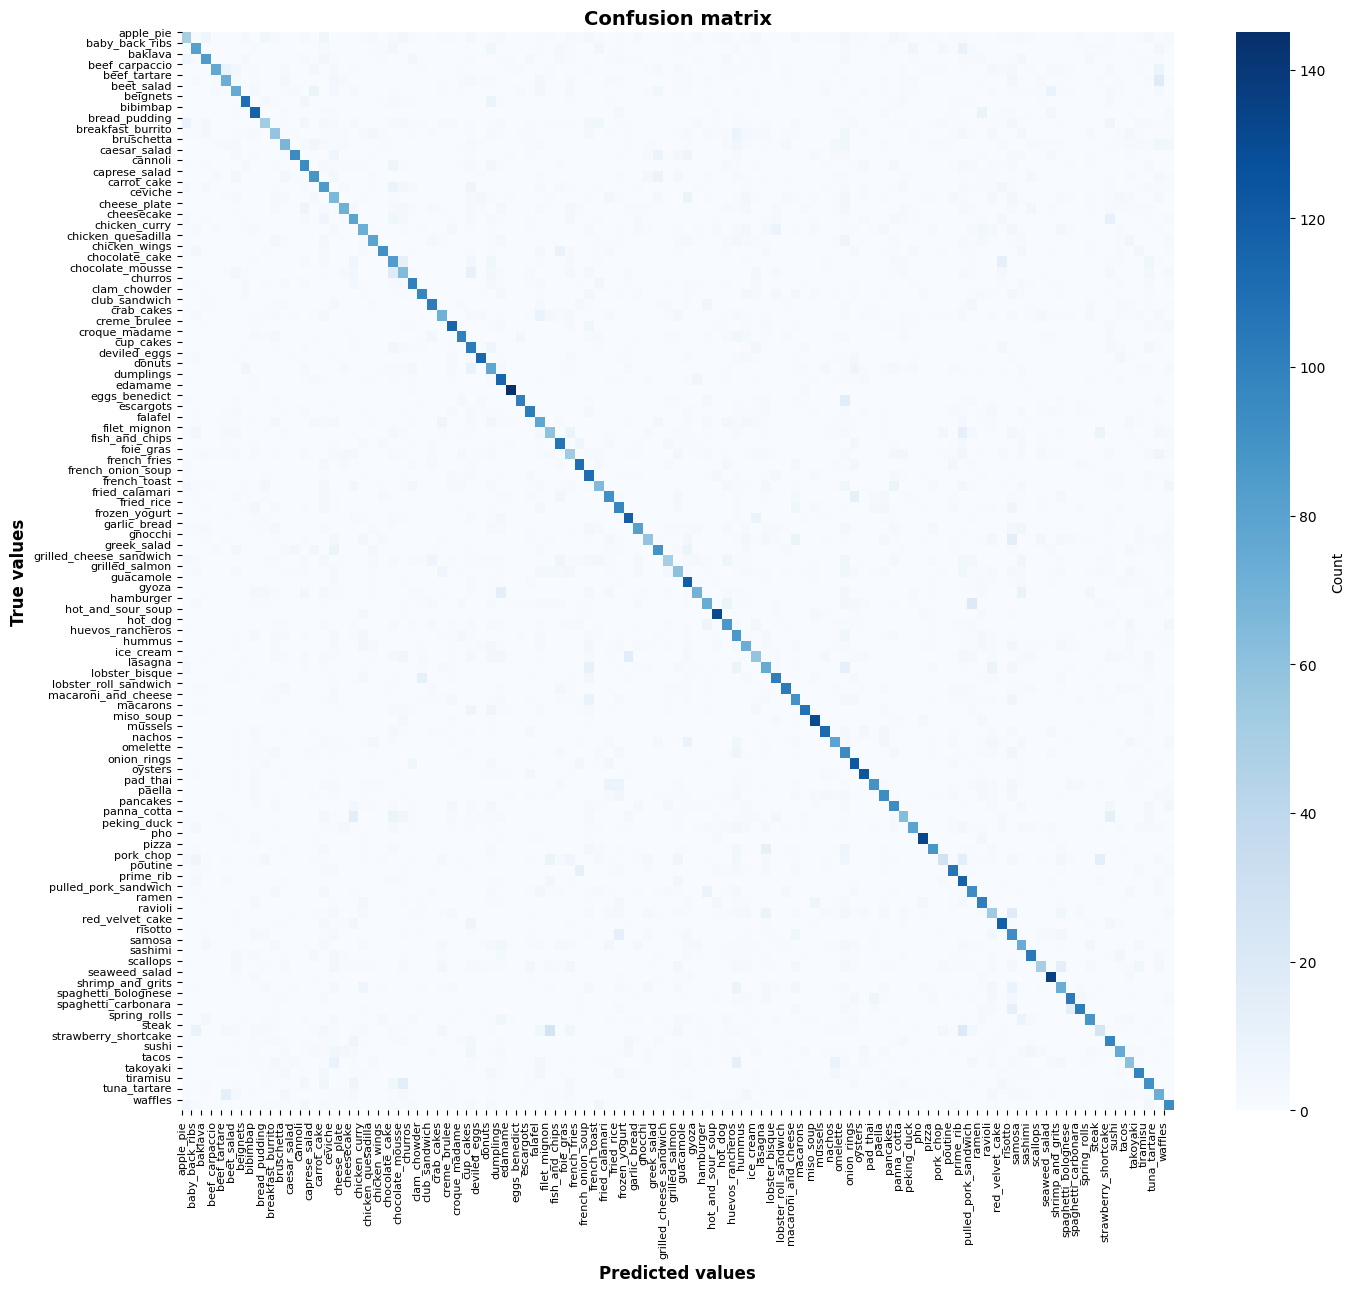

In [19]:
cm=confusion_matrix(val_labels, val_preds)

fig, ax=plt.subplots(figsize=(16, 14))
sns.heatmap(cm, fmt='d', cmap='Blues', ax=ax, cbar_kws={'label': 'Count'})
ax.set_xlabel('Predicted values', fontsize=12, fontweight='bold')
ax.set_ylabel('True values', fontsize=12, fontweight='bold')
ax.set_xticks(np.arange(NUM_CLASSES))
ax.set_yticks(np.arange(NUM_CLASSES))
ax.set_title('Confusion matrix', fontsize=14, fontweight='bold')

class_names=[val_dataset.get_class_name(i) for i in range(NUM_CLASSES)]
ax.set_xticklabels(class_names, rotation=90, fontsize=8)
ax.set_yticklabels(class_names, rotation=0, fontsize=8)

plt.savefig('figures/confusion_matrix', dpi=300, bbox_inches='tight')
plt.show()

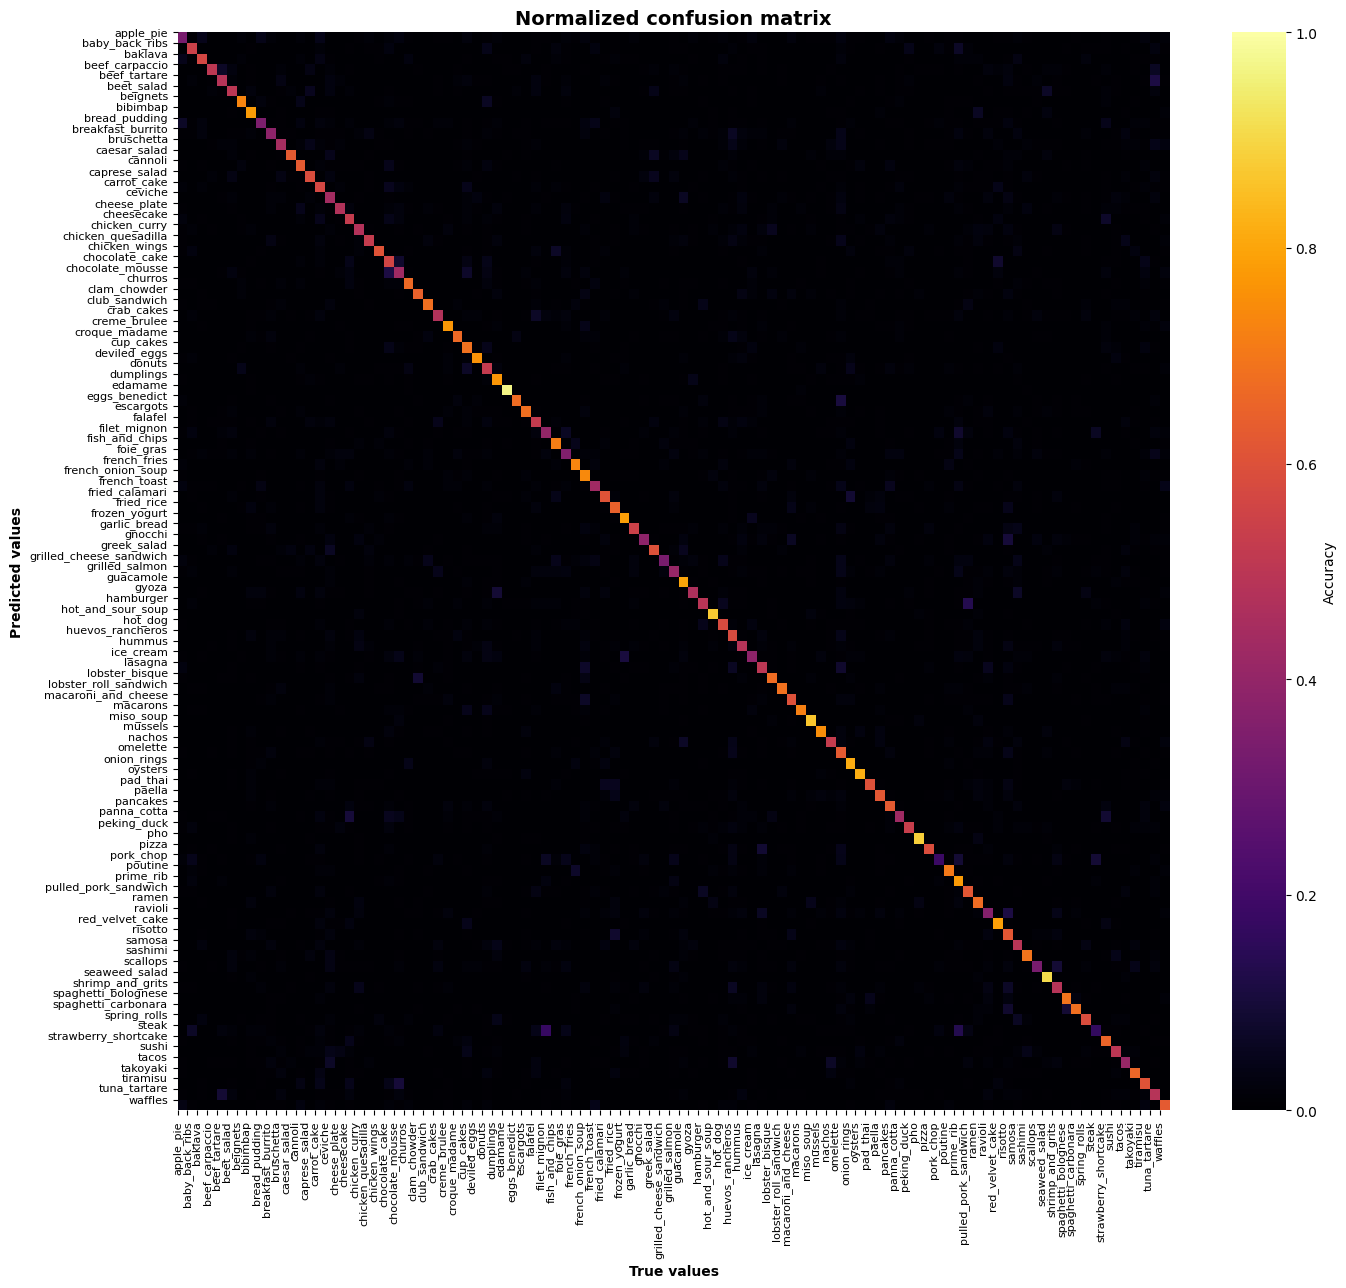

In [20]:
cm_normalized=cm.astype('float')/cm.sum(axis=1)[:, np.newaxis]

fig, ax=plt.subplots(figsize=(16, 14))
sns.heatmap(cm_normalized, fmt='.2f', cmap='inferno', ax=ax, vmin=0, vmax=1, cbar_kws={'label':'Accuracy'})
ax.set_xlabel('True values', fontsize=10, fontweight='bold')
ax.set_ylabel('Predicted values', fontsize=10, fontweight='bold')
ax.set_xticks(np.arange(NUM_CLASSES))
ax.set_yticks(np.arange(NUM_CLASSES))
ax.set_title('Normalized confusion matrix', fontsize=14, fontweight='bold')

class_names=[val_dataset.get_class_name(i) for i in range(NUM_CLASSES)]
ax.set_xticklabels(class_names, rotation=90, fontsize=8)
ax.set_yticklabels(class_names, rotation=0, fontsize=8)

plt.savefig('figures/normalized_confusion_matrix', dpi=300, bbox_inches='tight')
plt.show()

In [ ]:
# Most misclassified classes
misclassified_items=[]
per_class_accuracy=cm.diagonal() / cm.sum(axis=1)
per_class_errors=1 - per_class_accuracy

for i in range(NUM_CLASSES):
    class_name=val_dataset.get_class_name(i)
    accuracy=per_class_accuracy[i]
    error=per_class_errors[i]
    total_samples=cm[i].sum()
    correct=cm[i, i]
    incorrect=total_samples-correct 

    mistaken_as=[]
    for j in range(NUM_CLASSES):
        if i != j and cm[i, j] > 0:
            mistaken_as.append((val_dataset.get_class_name(j), cm[i, j]))
    mistaken_as.sort(key=lambda x: x[1], reverse=True)

    misclassified_items.append({
        'class_name': class_name,
        'accuracy': accuracy,
        'error_rate': error,
        'total': total_samples,
        'correct': correct,
        'incorrect': incorrect,
        'mistaken_as': mistaken_as[:3] if mistaken_as else []
    })

misclassified_df=pd.DataFrame(misclassified_items)
misclassified_df=misclassified_df.sort_values('error_rate', ascending=False)

# print('Most misclassified classes')
# for i, row in misclassified_df.head(3).iterrows(): 
#     print(f'\n{i}. {row['class_name']}')
#     print(f'Accuracy: {row['accuracy']:.2f} | Error rate: {row['error_rate']:.2f}')
#     print(f'Total samples: {row['total']}')
#     print(f'Correct: {row['correct']} | Incorrect: {row['incorrect']}')

# print('\nLeast misclassified classes')
# for i, row in misclassified_df.tail(3).iterrows():
#     print(f'\n{i}. {row['class_name']}')  
#     print(f'Accuracy: {row['accuracy']:.2f} | Error rate: {row['error_rate']:.2f}')
#     print(f'Total samples: {row['total']}')
#     print(f'Correct: {row['correct']} | Incorrect: {row['incorrect']}')

misclassified_df.to_csv(f'{SAVE_RESULTS_PATH}/misclassified_df.csv', index=False)

In [ ]:
fig, ax=plt.subplots(1, 2, figsize=(12, 6))

top20=misclassified_df.head(20)

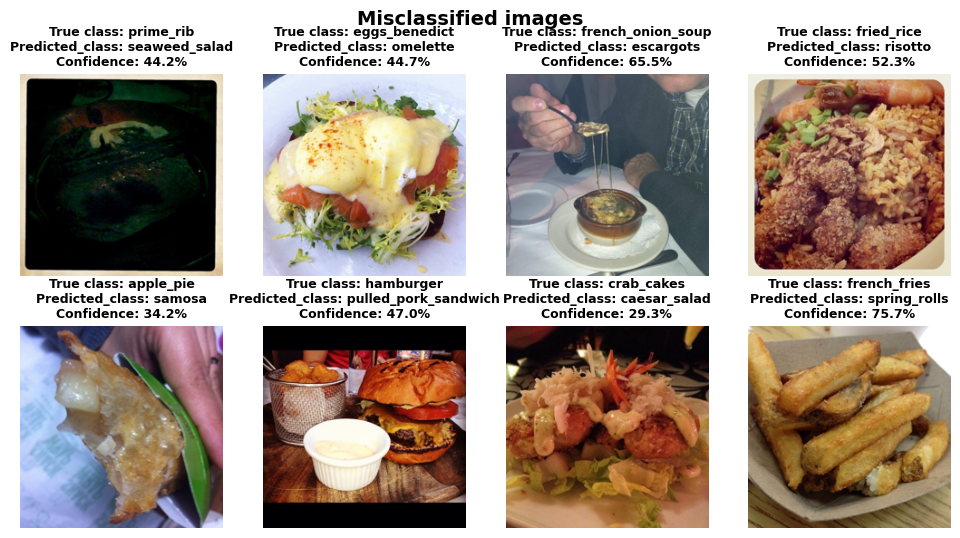

In [182]:
# Misclassified images
fig, ax=plt.subplots(2, 4, figsize=(12, 6))
ax=ax.flatten()

misclassified_idx=np.where(val_labels != val_preds)[0] # Indices of misclassified images

show_idx=np.random.choice(misclassified_idx, min(8, len(misclassified_idx)), replace=False) # Indices of shown images

for idx, show_idx in enumerate(show_idx):
    image_path=val_dataset.df.iloc[show_idx]['image_path']
    img=Image.open(image_path).convert('RGB')
    img=img.resize((IMG_SIZE, IMG_SIZE))

    true_class=val_dataset.get_class_name(val_labels[show_idx])
    pred_class=val_dataset.get_class_name(val_preds[show_idx])
    confidence=val_probs[show_idx][val_preds[show_idx]]*100
   
    ax[idx].imshow(img)
    ax[idx].set_title(f'True class: {true_class}\nPredicted_class: {pred_class}\nConfidence: {confidence:.1f}%', fontsize=9, fontweight='bold')
    ax[idx].axis('off')

plt.suptitle('Misclassified images', fontsize=14, fontweight='bold')
plt.savefig('figures/misclassified_images', dpi=300, bbox_inches='tight')
plt.show()